In [1]:
import os
import sys
sys.path.insert(0, '/hkfs/work/workspace/scratch/cc7738-benchmark_tag/TAPE_chen/core')
import copy as cp
import numpy as np
import networkx as nx
import torch 
import os.path as osp
import matplotlib.pyplot as plt
from data_utils.load_data_nc import (
    load_graph_cora, 
    load_graph_pubmed, 
    load_tag_arxiv23, 
    load_graph_ogbn_arxiv
)
from graphgps.encoder.seal import do_edge_split, do_ogb_edge_split
from torch_geometric.utils import to_scipy_sparse_matrix
from ogb.linkproppred import PygLinkPropPredDataset, Evaluator
from torch_geometric.datasets import Planetoid


/home/aifb/cc7738/anaconda3/envs/EAsF/lib/python3.8/site-packages/torch_geometric/graphgym/imports.py:14: UserWarning: Please install 'pytorch_lightning' via  'pip install pytorch_lightning' in order to use GraphGym
  warnings.warn("Please install 'pytorch_lightning' via  "


In [5]:
dataset = 'custom-cora'
fast_split = True
color_list = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', 
              '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', 
              '#bcbd22', '#17becf', '#ff9896']

data_list = ['custom-cora', 'custom-arxiv_2023', 
             'custom-pubmed', 'custom-ogbn_arxiv', 
             'obgl-ppa', 'ogbl-collab', 'ogbl-ddi',
             'ogbl-citation2', 'ogbl-wikikg2', 'ogbl-vessel', 'ogbl-biokg',
             'Cora', 'CiteSeer', 'PubMed']


In [6]:
def load_graph(dataset: str):
    if dataset == 'custom-pubmed':
        data = load_graph_pubmed(False)
    elif dataset == 'custom-cora':
        data, _ = load_graph_cora(False)
    elif dataset == 'custom-arxiv_2023':
        data, _ = load_tag_arxiv23()
    elif dataset == 'custom-ogbn_arxiv':
        data = load_graph_ogbn_arxiv(False)
    elif dataset.startswith('ogbl'):
        data = PygLinkPropPredDataset(name=dataset)
        split_edge = data.get_edge_split()
        data = data[0]
        if dataset.startswith('ogbl-vessel'):
            # normalize node features
            data.x[:, 0] = torch.nn.functional.normalize(data.x[:, 0], dim=0)
            data.x[:, 1] = torch.nn.functional.normalize(data.x[:, 1], dim=0)
            data.x[:, 2] = torch.nn.functional.normalize(data.x[:, 2], dim=0)   
    else:
        path = osp.join('dataset', dataset)
        data = Planetoid(path, dataset)
        split_edge = do_ogb_edge_split(data, fast_split)
        data = data[0]
        data.edge_index = split_edge['train']['edge'].t()
    return data

Dataset: custom-cora


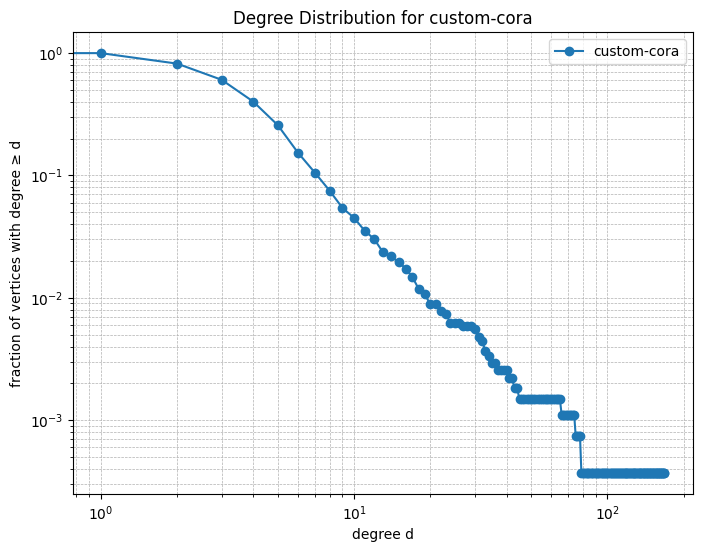

Dataset: custom-arxiv_2023


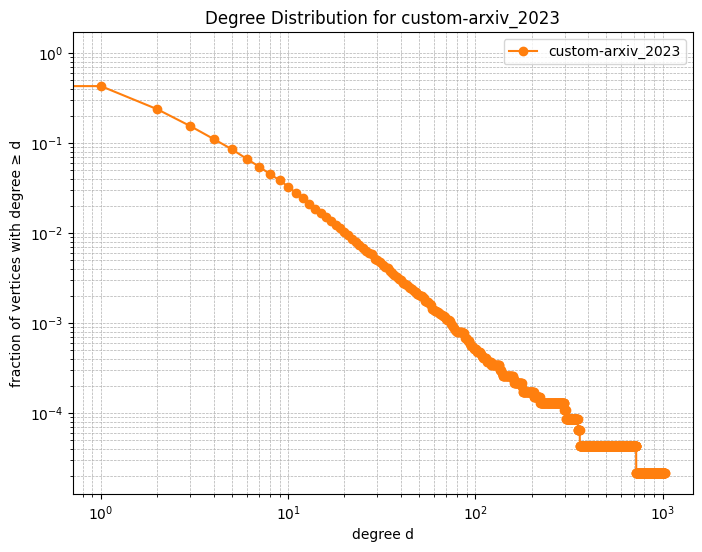

Dataset: custom-pubmed


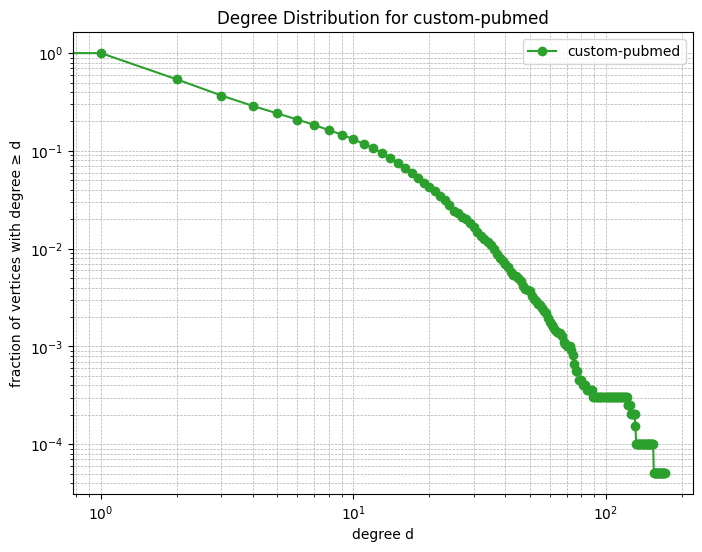

/hkfs/work/workspace/scratch/cc7738-benchmark_tag/TAPE_chen/core/data_utils/load_data_nc.py:390: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(data.x).float()


Dataset: custom-ogbn_arxiv


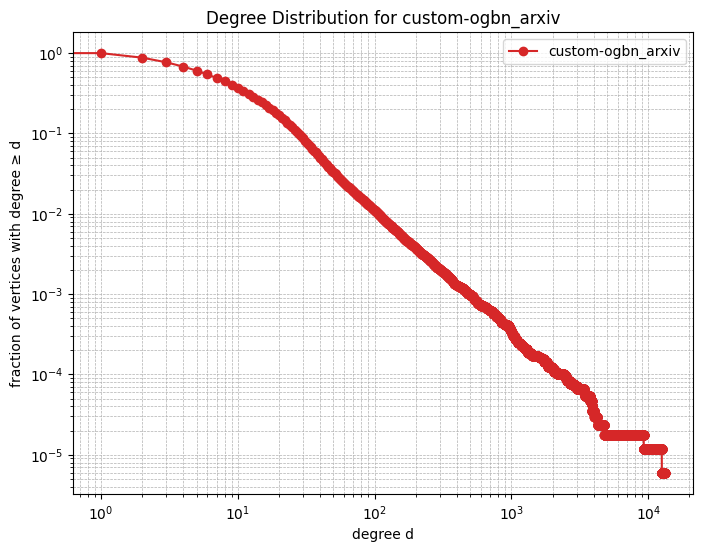

HTTPError: HTTP Error 404: Not Found

In [9]:
for dataset, color in zip(data_list, color_list):
    fast_split = True

    try:
        data = load_graph(dataset)
    except ValueError as e:
        print(e)
        continue
        
    print(f"Dataset: {dataset}")
    adj = to_scipy_sparse_matrix(data.edge_index)

    G = nx.from_scipy_sparse_array(adj)
    # Get the degree of each node
    degrees = [G.degree(n) for n in G.nodes()]

    # Compute degree distribution
    degree_counts = np.bincount(degrees)
    degree_distribution = degree_counts / len(G.nodes())

    # Compute cumulative degree distribution
    cumulative_distribution = np.cumsum(degree_distribution[::-1])[::-1]

    # Individual plot for each dataset
    plt.figure(figsize=(8, 6))
    plt.loglog(range(len(cumulative_distribution)), cumulative_distribution, marker='o', linestyle='-', color=color, label=dataset)
    plt.legend(loc='upper right')
    plt.xlabel('degree d')
    plt.ylabel('fraction of vertices with degree ≥ d')
    plt.title(f'Degree Distribution for {dataset}')
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.show()